# Maximum Extended Fit 

Example of a 1D-polynonmial and 1D-polynomial+gaus Maximum Likelihood fit and Extended Maximum Likelihood fit

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Nov 30 19:19:36 2018


In [2]:
import numpy as np
import scipy.stats       as stats
import matplotlib.pyplot as plt
import scipy.optimize    as optimize

from scipy.stats    import rv_continuous
from scipy.optimize import minimize

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1.  PDF and ML fit to a 1D-polynomial


The 1D-polinomial pdf is defined in an interval $[a, b]$. Notice that the pdf pivotes in the center $c = (a+b)/2$ with a range in slope $[ -2/(b-a)^2, \; 2/(b-a)^2]$

We parameterize the 1D-polinomial pdf as: 

$f(x | m ) = m * (x - c) + b$,

where $c = (a+b)/2$ and $b = 1/(b-a)$.

### define a pdf-class for 1D-polynomial

In [4]:
class Pol1D(rv_continuous):
    
    def _pdf(self, x, mslope):
        e0, e1 = self.a, self.b
        ec, b  = (e0 +e1)/2., 1/(e1-e0)
        return mslope*(x-ec) + b
       
    def _argcheck(self, mslope):
        e0, e1 = self.a, self.b
        de = e1 - e0
        ok = (mslope >= -2./(de*de)) & (mslope <= 2./(de*de)) # allowed range of the slope 
        return ok

In [5]:
e0, e1 = -1., 1.
mslope = -0.25
print('range e   : ', e0, e1)
print('slope     : ', mslope)
print('max slope : ', 2./((e1-e0)*(e1-e0)))

range e   :  -1.0 1.0
slope     :  -0.25
max slope :  0.5


### generate n-randon events 

In [6]:
p1 = Pol1D(a = e0, b = e1, shapes = 'mslope')
n = 200
print('computing random events ...', n)
xs = p1.rvs(size = n, mslope = mslope) 

computing random events ... 200


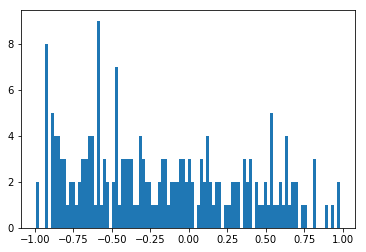

In [7]:
plt.hist(xs, 100);

### compute -2 log likelihood

In [8]:
llval = -2.*np.sum(p1.logpdf(xs, mslope = mslope))
print('-2 log like : ', llval)

-2 log like :  256.2758392283021


### Scan the -2 log likelihood in the parameter interval

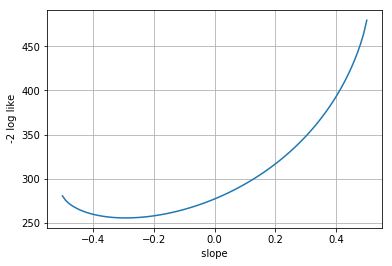

In [9]:
ms = np.linspace(-0.5, 0.5, 100)

llfun = lambda mi : -2.*np.sum(p1.logpdf(xs, mslope = mi))

lls = [llfun(mi) for mi in ms]

plt.plot(ms, lls)
plt.grid()
plt.xlabel(' slope ')
plt.ylabel(' -2 log like');

### Maximum Likelihood fit

In [10]:
def ll_fun(xs):
    def llfit(mus):
        mslope = mus[0]
        return -2.*np.sum(p1.logpdf(xs, mslope = mslope))
    return llfit

In [11]:
llfit  = ll_fun(xs) 
mus0   = np.array([0.1, ])   # initial guess
res    = minimize(llfit, mus0, method='Nelder-Mead' )
mushat = res.x
print(' true parameters         : ', mslope)
print(' initial guess parameters: ', *mus0)
print(' estimated parameters    : ', *mushat)

 true parameters         :  -0.25
 initial guess parameters:  0.1
 estimated parameters    :  -0.29234374999999924


# 2. PDF and MLF to a 1D-polynomial + gaus

The pdf is defined in a range $[a, b]$. The 1D-polynomial has only 1-degree of freedom (the slope) which is also constrained in a range. We consider that the gaus pdf is contained in the range $[a, b]$. And a fraction $f$ of the gaussian with respect the 1D-polynomial. 

The pdf is:

$f(x | \mu, \sigma, m, f) = f * \rm{gaus} \,(x | \mu, \sigma) + (1-f) * \rm{polynom1D}\,(x | m)$

### define a pdf-class for 1D-polynomial + gaus 

In [13]:
class Pol1DGaus(rv_continuous):        

    def _pdf(self, x, mu, sigma, mslope, f):

        pgaus = stats.norm.pdf(x, loc=mu, scale = sigma)

        e0, e1 = self.a, self.b
        ec, b = (e0 +e1)/2., 1/(e1-e0)
        ppol1 =  mslope*(x-ec) + b
        
        ptot = f * pgaus + (1-f)*ppol1
        return ptot
    
    def weight(self, x, mu, sigma, mslope, f):
        
        pgaus = stats.norm.pdf(x, loc=mu, scale = sigma)

        e0, e1 = self.a, self.b
        ec, b = (e0 +e1)/2., 1/(e1-e0)
        ppol1 =  mslope*(x-ec) + b
        
        pg =    f  * pgaus
        pp = (1-f) * ppol1
        ws = pg/(pg + pp)
        return ws, pg, pp
        
    def _argcheck(self, mu, sigma, mslope, f):
        e0, e1 = self.a, self.b
        de = e1 - e0
        ok = (mslope >= -2./(de*de)) & (mslope <= 2./(de*de)) # limits in the slope
        ok = ok & (mu > e0) & (mu < e1)& (sigma > 0) & (sigma < (e1-e0)/3.) # limits in the gausian
        ok = ok & (f >= 0) & (f <=1.) # limits in the fraction
        return ok

In [29]:
e0, e1               = -10., 10.
mu, sigma, mslope, f =   0.,  1., -0.002, 0.2

mslope_max           = 2./((e1-e0)*(e1-e0))

print('range e   : ', e0, e1)
print('slope     : ', mslope)
print('max slope : ', mslope_max)
print('gaussian mu, sigma  : ', mu, sigma)
print('gaussian fraction   : ', f)

range e   :  -10.0 10.0
slope     :  -0.002
max slope :  0.005
gaussian mu, sigma  :  0.0 1.0
gaussian fraction   :  0.2


### generate n-randon events 

In [49]:
pg = Pol1DGaus(a = e0, b = e1, shapes = 'mu, sigma, mslope, f')
n = 10000
print('computing random events (it is slow...)', n)
xs = pg.rvs(size = n, mu = mu, sigma = sigma, mslope = mslope, f = f) 

computing random events (it is slow...) 10000


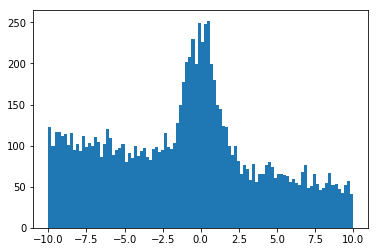

In [50]:
plt.hist(xs, 100);

### compute -2 log likelihood

In [51]:
llval = -2.*np.sum(pg.logpdf(xs, mu = mu, sigma = sigma, mslope = mslope, f = f))
print('-2 log like : ', llval)

-2 log like :  57990.98723354929


### Scan the -2 log likelihood in the parameter interval

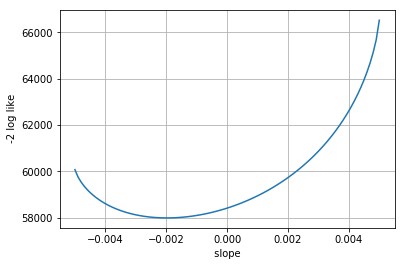

In [52]:
ms = np.linspace(-mslope_max, mslope_max, 100)

llfun = lambda mi : -2.*np.sum(pg.logpdf(xs, mu= mu, sigma = sigma, mslope = mi, f = f))

lls = [llfun(mi) for mi in ms]

plt.plot(ms, lls)
plt.grid()
plt.xlabel(' slope ')
plt.ylabel(' -2 log like');

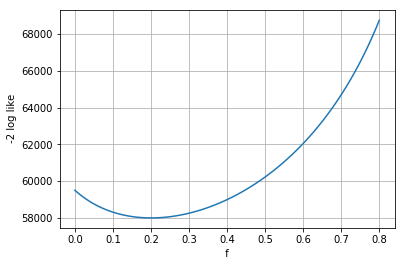

In [53]:
fs = np.linspace(0., 0.8, 100)

llfun = lambda fi : -2.*np.sum(pg.logpdf(xs, mu= mu, sigma = sigma, mslope = mslope, f = fi))

lls = [llfun(fi) for fi in fs]

plt.plot(fs, lls)
plt.grid()
plt.xlabel(' f ')
plt.ylabel(' -2 log like');

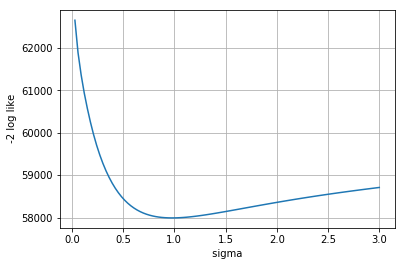

In [54]:
sigmas = np.linspace(0, 3., 100)

llfun = lambda si : -2.*np.sum(pg.logpdf(xs, mu= mu, sigma = si, mslope = mslope, f = f))

lls = [llfun(si) for si in sigmas]

plt.plot(sigmas, lls)
plt.grid()
plt.xlabel(' sigma ')
plt.ylabel(' -2 log like');

### Maximum Likelihood fit

In [55]:
def ll_fun(xs):
    def llfit(mus):
        mu, sigma, mslope, f = mus[0], mus[1], mus[2], mus[3]
        return -2.*np.sum(pg.logpdf(xs, mu = mu, sigma = sigma, mslope = mslope, f = f))
    return llfit

In [56]:
llfit  = ll_fun(xs) 
mus0   = np.array([1., 0.5, 0., 0.5])   # initial guess
res    = minimize(llfit, mus0, method='Nelder-Mead' )
mushat = res.x
print(' true parameters         : ', mu, sigma, mslope, f)
print(' initial guess parameters: ', *mus0)
print(' estimated parameters    : ', *mushat)

 true parameters         :  0.0 1.0 -0.002 0.2
 initial guess parameters:  1.0 0.5 0.0 0.5
 estimated parameters    :  0.03000509867423822 0.9724856260873607 -0.0019869026516839555 0.19787299283346457


### Show that the with the weights we can recuperate original signal and bkg distributions

In [64]:
mu, sigma, mslope, f = mushat[0], mushat[1], mushat[2], mushat[3]
ws, _, _ = pg.weight(xs, mu = mu, sigma = sigma, mslope = mslope, f = f)

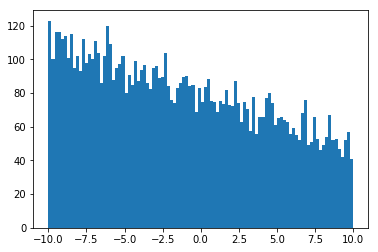

In [69]:
plt.hist(xs, bins = 100, weights = (1-ws));

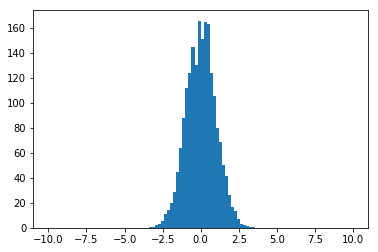

In [77]:
plt.hist(xs, bins = 100, weights = ws);

In [83]:
hys, hxs = np.histogram(xs, bins = 100, weights = ws);
hxs  = (hxs[1:] + hxs[:-1])/2.
hn0  = np.sum(hys)
hmu  = np.sum(hys*hxs)/hn0
hsig = np.sum(hys*(hxs-hmu)*(hxs-hmu))/hn0
print(hn0, hmu, hsig)

1978.7548236958219 0.028750600174662997 0.9477112612291627


# 3. Extended Maximun Likelihood fit to a 1D-Polynomial + gaus

We consider a gaus pdf and a 1D-Polynomial pdf, instead of f as the fraction of events, we consider a poisson distribution of the total number of events with a mean: $\nu_g + \nu_p$, where $\nu_g$ is the expected number of gaussian events and $\nu_p$ the expected number of the 1D-polynomial.

The pdf is:

$f(n, {\bf x} | \mu, \sigma, m, \nu_g, \nu_p) = \rm{poisson}(n | \nu_g + \nu_p) \, \left(\frac{\nu_g}{\nu_g + \nu_p} \, \rm{gaus}({\bf x} | \mu, \sigma) + \frac{\nu_p}{\nu_g+\nu_p} \, \rm{poly1D}({\bf x} | m) \right)$

In [84]:
e0, e1             = -10., 10.
mu, sigma, mslope  =   0.,  1., -0.002
nug, nup           =  100, 400
f = 1.*nug/(nug+nup)

print('range e   : ', e0, e1)
print('slope     : ', mslope)
print('max slope : ', 2./((e1-e0)*(e1-e0)))
print('gaussian mu, sigma   : ', mu, sigma)
print('expected gauss, polynomial events: ', nug, nup)
print('gaussian fraction   : ', f)

range e   :  -10.0 10.0
slope     :  -0.002
max slope :  0.005
gaussian mu, sigma   :  0.0 1.0
expected gauss, polynomial events:  100 400
gaussian fraction   :  0.2


### generate random-events with the extended pdf

In [85]:
pg = Pol1DGaus(a = e0, b = e1, shapes = 'mu, sigma, mslope, f')

def pg_experiment(mu, sigma, mslope, nug, nup):
    ng = stats.poisson.rvs(size = 1, mu = nug)
    np = stats.poisson.rvs(size = 1, mu = nup)
    n0 = ng[0] + np[0]
    print('number of events : ', n0)
    f = nug/(nug + nup)
    xs = pg.rvs(size = n0, mu = mu, sigma = sigma, mslope = mslope, f = f)
    return xs

In [86]:
print('generating experiment (it can be slow...)')
xs = pg_experiment(mu, sigma, mslope, nug, nup)

generating experiment (it can be slow...)
number of events :  528


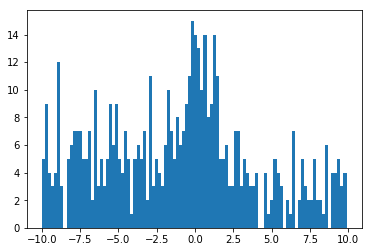

In [87]:
plt.hist(xs, 100);

### Compute Extened -2 Log likelihood

In [88]:
def llext_fun(xs):
    def llfit(mus): 
        mu, sigma, mslope, nug, nup = mus[0], mus[1], mus[2], mus[3], mus[4]
        n = len(xs)
        llog1 = -2.*np.sum(np.log(stats.poisson.pmf(n, mu = nug + nup)))
        f = float(nug)/float(nug + nup)
        llog2 = -2.*np.sum(pg.logpdf(xs, mu = mu , sigma = sigma, mslope = mslope, f = f))
        return llog1 + llog2
    return llfit

In [89]:
mustrue = np.array([mu, sigma, mslope, nug, nup])
llfit   = llext_fun(xs)
print('Extended -2 log like ', llfit(mustrue))

Extended -2 log like  3071.776151057269


### Extended Maximum Likelihood Fit

In [90]:
mus0 = np.array([1., 2., 0., 50, 600])
res  = minimize(llfit, mus0, method='Nelder-Mead' )
mushat = res.x
print(' true parameters         : ', *mustrue)
print(' initial guess parameters: ', *mus0)
print(' estimated parameters    : ', *mushat)

 true parameters         :  0.0 1.0 -0.002 100.0 400.0
 initial guess parameters:  1.0 2.0 0.0 50.0 600.0
 estimated parameters    :  0.3285387667214729 1.0049172483444218 -0.0021208486047537387 107.21346235022382 420.7864982236287


In [91]:
print('Done!')

Done!
